In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [3]:
import matplotlib.pyplot as plt
import random
import numpy as np 
from scipy.stats import norm, multivariate_normal
from typing import Any, Dict, List

# Custom code
from src.synthetic.coordination_generator import DiscreteCoordinationGenerator
from src.synthetic.vocalics_generator import VocalicsGenerator, VocalicsGeneratorForDiscreteCoordination
from src.transformations.series_transformations import embed_features_across_dimensions
from src.inference.vocalics import estimate_discrete_coordination

### Binary Coordination (hard coupling)

We start with coordination as a binary variable. Vocalic series A and B are observed at different time scales. A single value of this series at a time step $t$ contains the average value of a specific vocalic feature whithin an utterance that ended at time $t$. If no utterance ended at that time, there's no link between the coordination variable and the vocalic series. That means the model structure is defined according to the data. The existance of coordination affects the coupling between series $A$ and $B$, that is, whether $B_t$ depends on $A_{t-1}$ and vice versa. 

We start by generating synthetic data for a model with the following parameters

$
\begin{align}
p(C_0) &\sim \text{Ber}(0) \\
p(C_t | C_{t-1}) &\sim \text{Bernoulli}\left( 
\begin{cases}
1 - p_{tc},~\text{if}~C_t = C_{t-1} \\
p_{tc},~\text{otherwise}
\end{cases}\right)\\
p(A) = p(B) &\sim \mathcal{N}(0, I) \\
p(A_{t(t_a)}|C_t, B_{t(t_b-1)}) &\sim p(A)^{1-C_t}\mathcal{N}(f(B_{t(t_b-1)}), I)^{C_t} \\
p(B_{t(t_b)}|C_t, A_{t(t_b-1)}) &\sim p(B)^{1-C_t}\mathcal{N}(f(A_{t(t_a-1)}), I)^{C_t}
\end{align}
$

This model makes a series of assumptions:

1. The process starts with no coordination 
2. Coordination is a discrete value (either it exists or not)
3. There's a $p_{tc}$ chance of change in the coordination from one time step to the next
4. Samples from one series are independent of each other, that means series A and B are sampled from their priors (standard normal) if there's no coordination. 
5. We start by setting $f(.)$ to be the identity function, that means coordination is observed as a simple linear coupling betweeen the series.

First we will generate a series of coordination values over time and then we generate series A and B for two vocalic features: pitch and intensity. We assume these features are sampled independently which, in practice, allows us to work with a multivatiate normal with diagonal covariance matrix for the last 3 equations above. 

In [7]:
SEED = 0 # For reproducibility
P_TC = 0.1 # Coordination is changed with small probability
MEAN_SHIFT = 0 # Identity function if 0. Inference is easier if != 0
OBSERVATION_DENSITY = 1 # Inference is harder if density is small

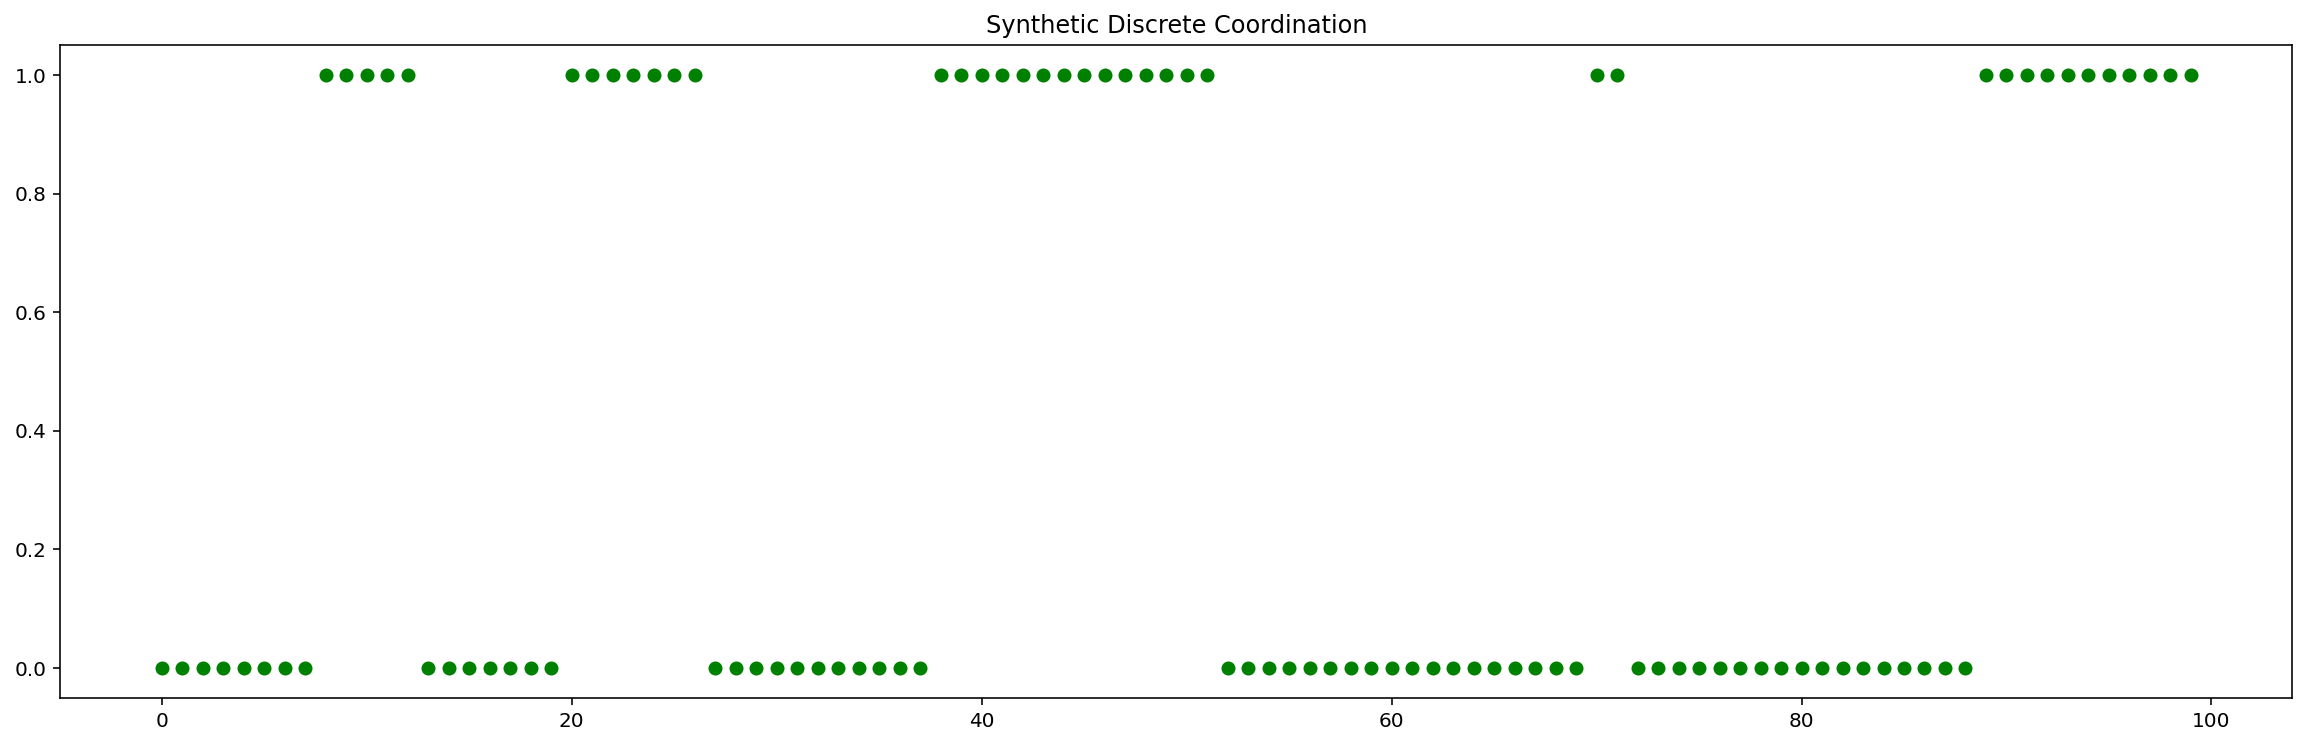

In [8]:
def plot_coordination(cs: List[float]):
    plt.figure(figsize=(20, 6))
    plt.scatter(range(len(cs)), cs, color="green")
    plt.title("Synthetic Discrete Coordination")

random.seed(SEED)
np.random.seed(SEED)
num_time_steps = 100
discrete_cs = DiscreteCoordinationGenerator(p_prior = 0, p_transition = P_TC).generate_evidence(num_time_steps)
plot_coordination(discrete_cs)

Text(0.5, 1.0, 'Synthetic Intensity')

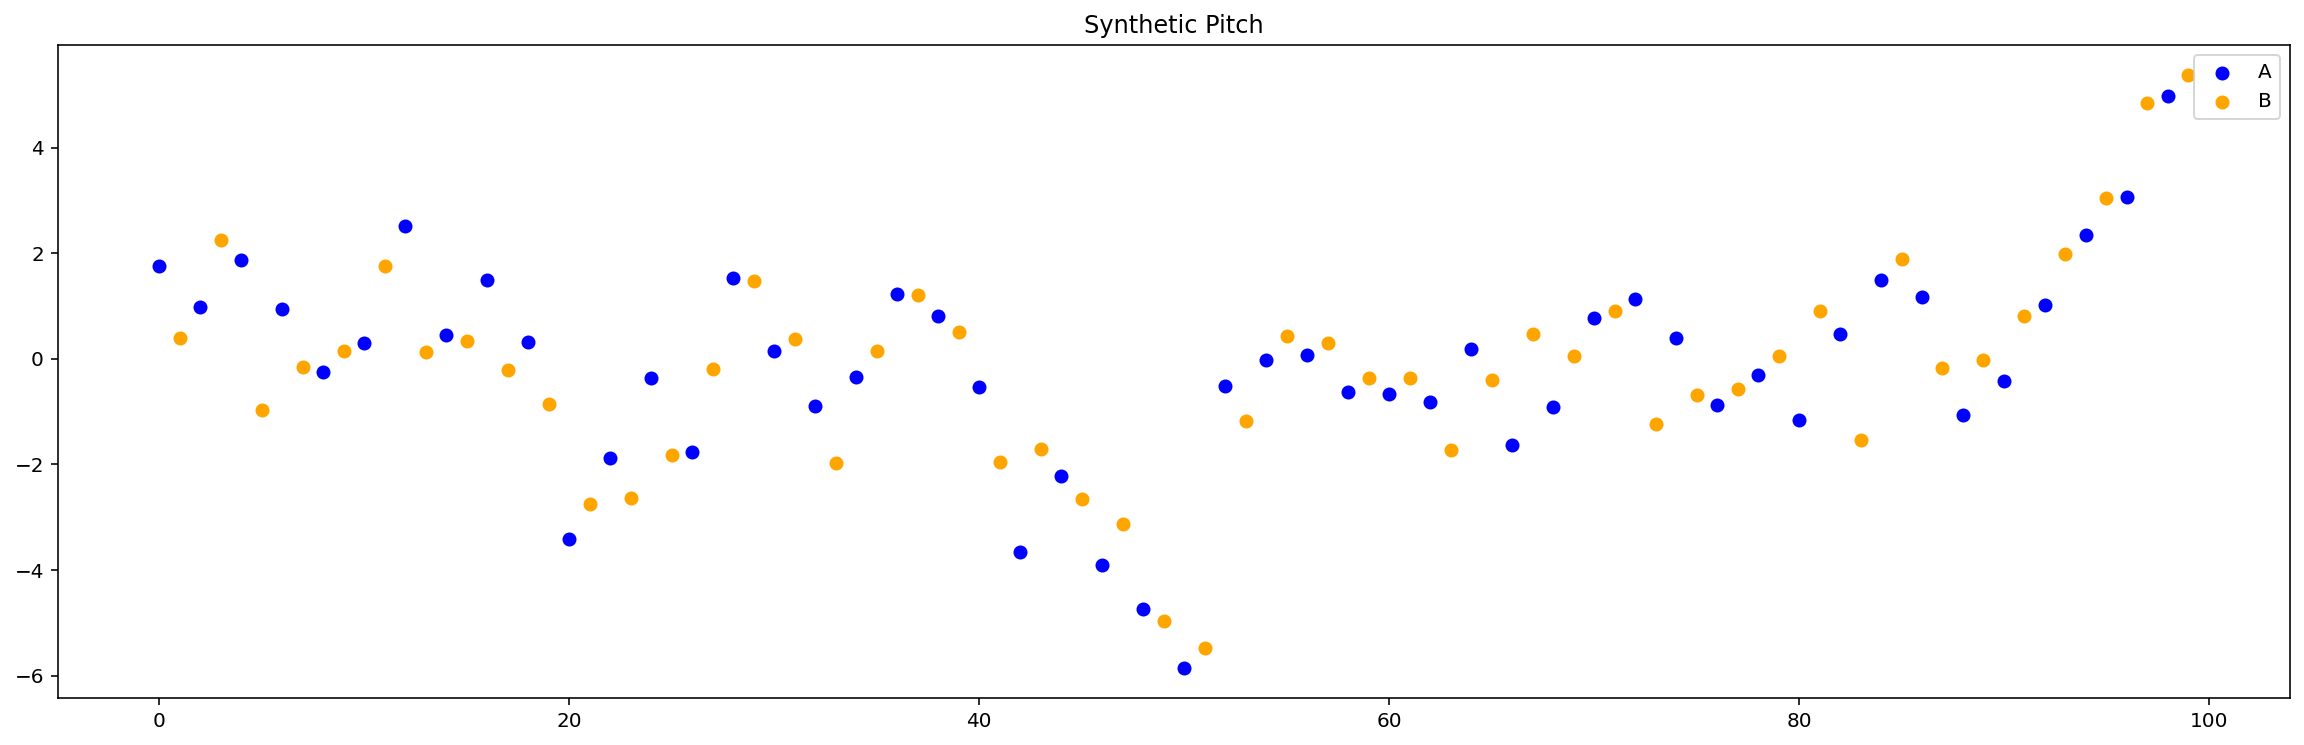

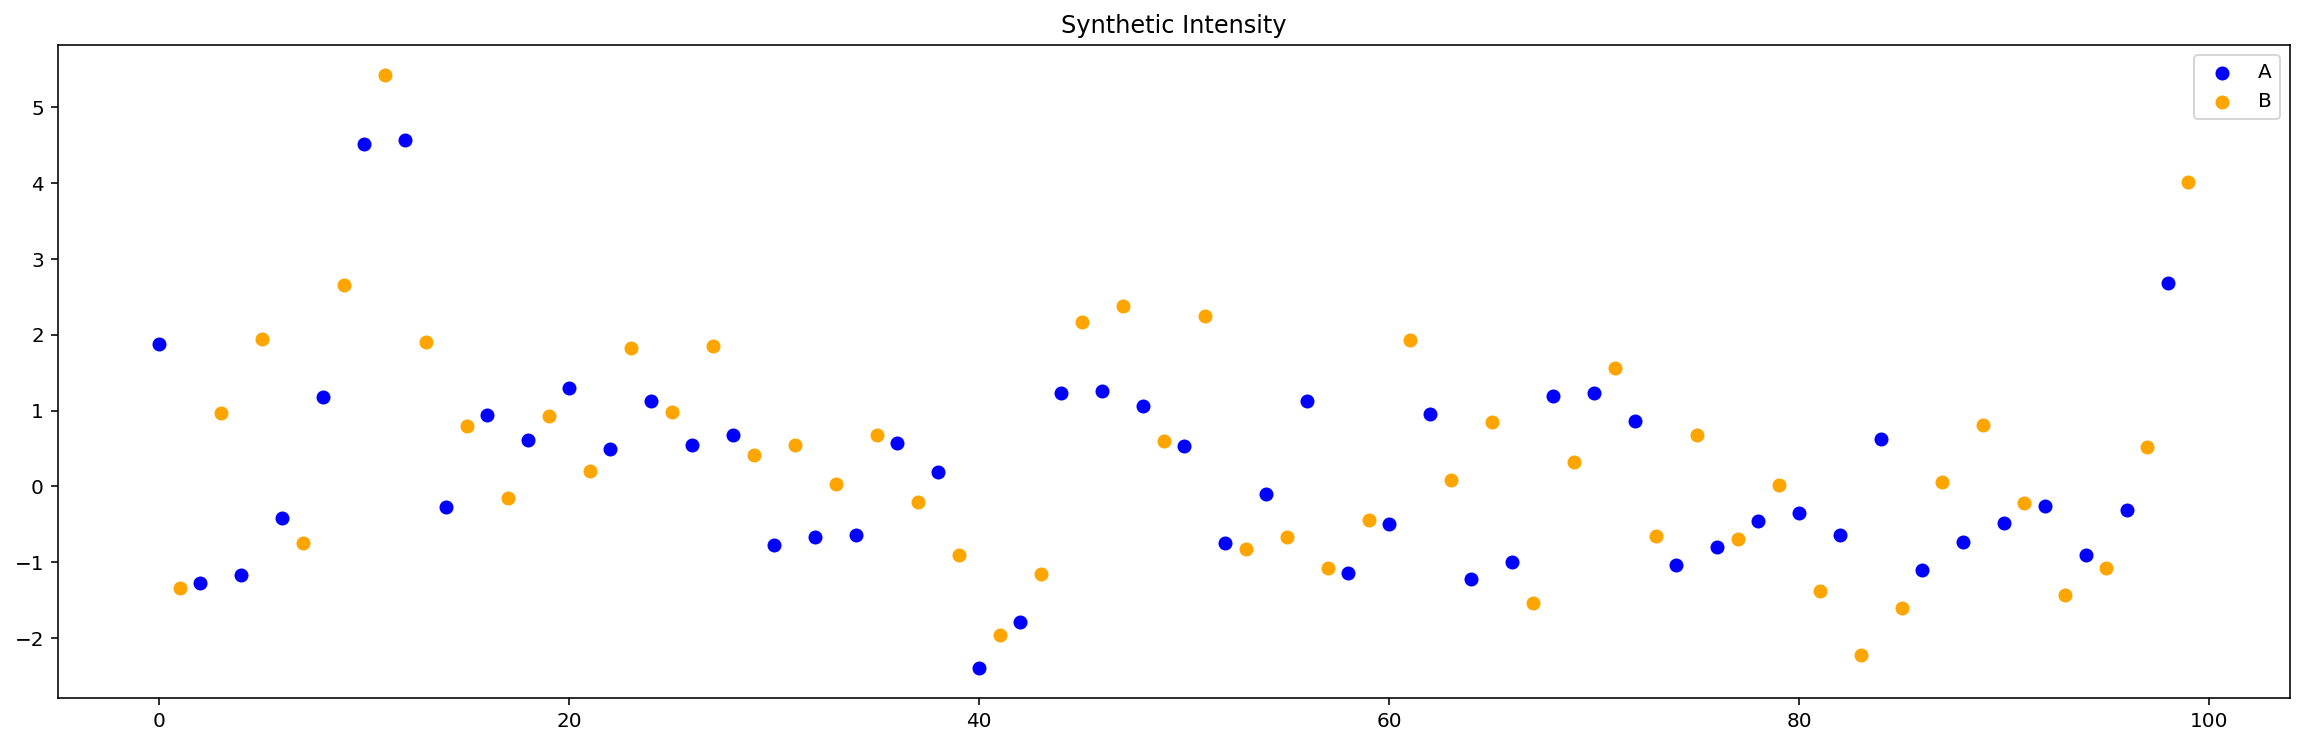

In [9]:
def plot_vocalic_series(series_a: List[float], series_b: List[float], marker: str = "o", 
                        ax: Any = None):
    if ax is None:
        plt.figure(figsize=(20, 6))
        ax = plt.gca()
    
    plt.scatter(range(len(series_a)), series_a, color="blue", label="A", marker=marker)
    plt.scatter(range(len(series_b)), series_b, color="orange", label="B", marker=marker)
    plt.legend()        
    
    return ax


random.seed(SEED)
np.random.seed(SEED)
vocalics_generator = VocalicsGeneratorForDiscreteCoordination(coordination_series=discrete_cs, 
                                                              vocalic_features=["pitch", "intensity"], 
                                                              time_scale_density=OBSERVATION_DENSITY, 
                                                              mean_shift_coupled=MEAN_SHIFT,
                                                              var_coupled=1)
series_a, series_b = vocalics_generator.generate_evidence()
ax_pitch = plot_vocalic_series(series_a["pitch"], series_b["pitch"])
ax_pitch.set_title("Synthetic Pitch")
ax_pitch = plot_vocalic_series(series_a["intensity"], series_b["intensity"])
ax_pitch.set_title("Synthetic Intensity")

### Inference

Based on the observed vocalic series component, we can infer the coordination at each time step. The joint distribution of coordination and vocalics components is

$
\begin{align}
p(C_{0:T}, A_{0,T_a}, B_{0,T_b}) = p(C_0)\prod^{T}_{t=1}p(C_t|C_{t-1})p(A_t|C_t, B_{t-1})p(B_t|C_t, A_{t-1})
\end{align}
$

Notice that for a certain $t$, $A_t$ and $B_t$ might not have been observed, which means we do not include their terms in the equation above, or they are replaced by 1 which has the same effect. Also, $B_{t-1}$ and $A_{t-1}$ refer to the last time values for the series were observed, thus that might not correspond to the actual $t-1$ time step. 

Inference here can be performed exactly using message passing because of the discrete nature of coordination.


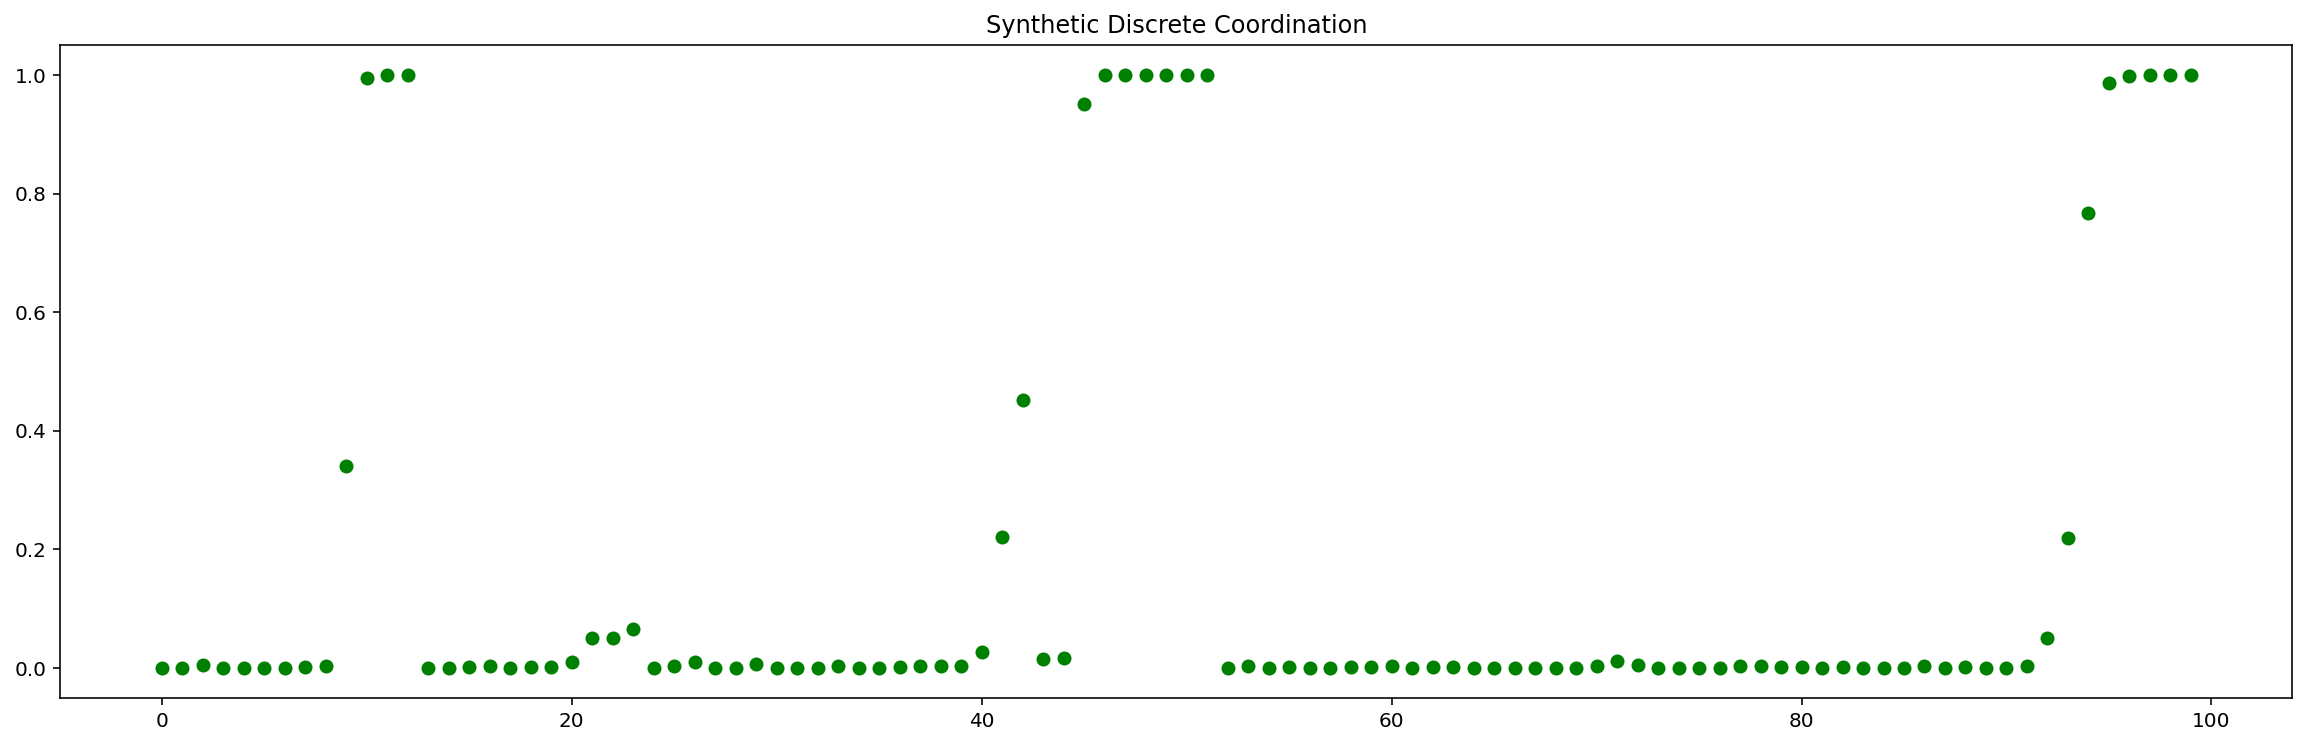

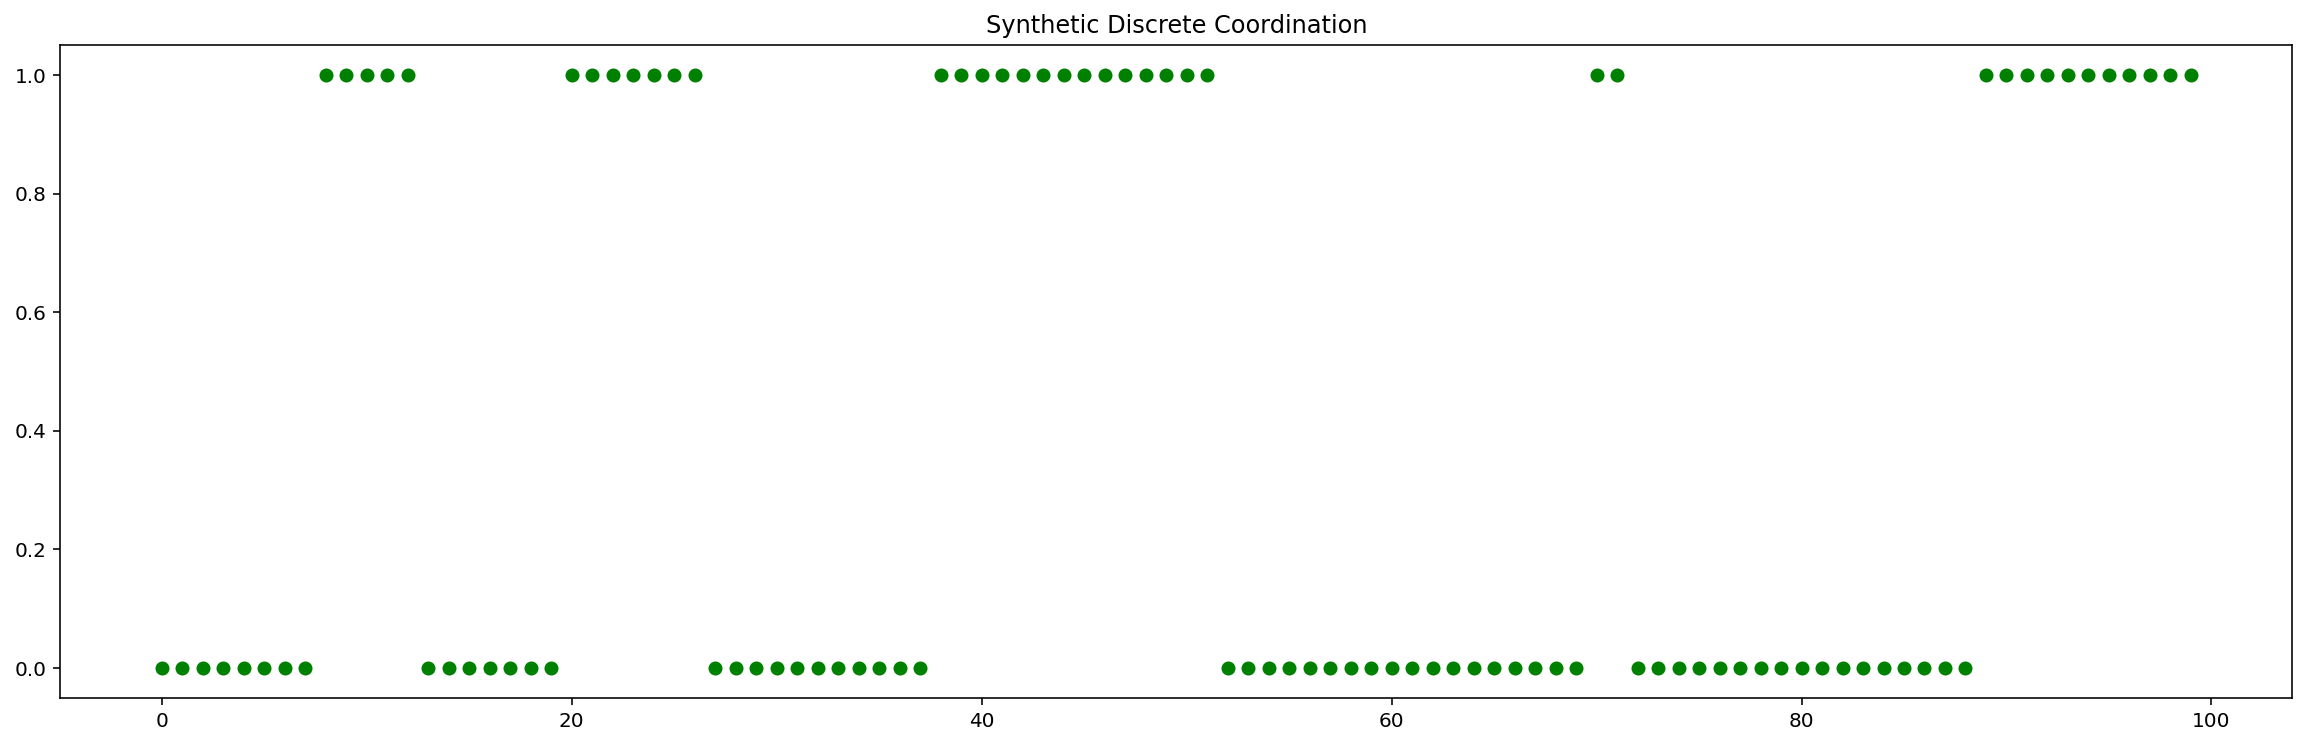

In [164]:
def pdf_ab(value: np.ndarray, previous_same: Any, previous_other: Any, coordination: float):
    pdf = (multivariate_normal.pdf(value) ** (1 - coordination)) * (
               multivariate_normal.pdf(value, mean=MEAN_SHIFT + previous_other) ** coordination)
    return np.prod(pdf)

multi_dim_a, mask_a = embed_features_across_dimensions(num_time_steps, series_a)
multi_dim_b, mask_b = embed_features_across_dimensions(num_time_steps, series_b)
marginals = estimate_discrete_coordination(multi_dim_a, multi_dim_b, 0, P_TC, pdf_ab, pdf_ab, mask_a, mask_b)

plot_coordination(marginals[:, 1])
plot_coordination(discrete_cs)

Coordination can be inferred reasonably provided that we have high density of observations. Low density will degrade the inference, which can be simulated by tweaking the OBSERVATION_DENSITY variable.

Shifting the mean when there's coordination improves inference since coupling is not the only thing that changes when there's coordination. This can also be simulated by changing the MEAN_SHIFT variable.